17:27:47 -05 WARNING: The simulation has zero size along the x axis, so using a 
             PML or absorbing boundary along that axis is incorrect. Use either 
             'Periodic' or 'BlochBoundary' along x. Using 'Periodic' boundary by
             default.                                                           

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


17:27:50 -05 WARNING: Mode field at frequency index 0, mode index 4 does not    
             decay at the plane boundaries.                                     

17:27:51 -05 WARNING: Mode field at frequency index 0, mode index 5 does not    
             decay at the plane boundaries.                                     

[2.12523117 1.9592221  1.75670895 1.51428931 1.4402224  1.43709893]


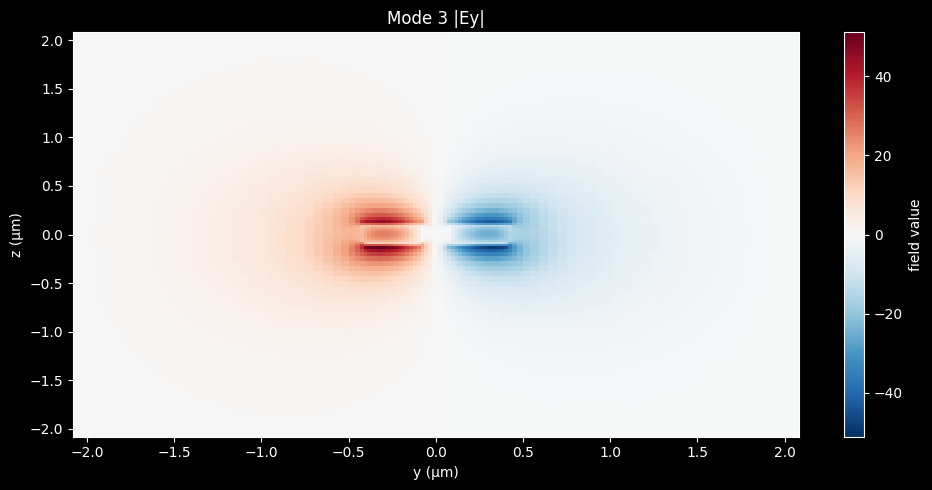

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
from tidy3d.plugins import waveguide
from tidy3d.plugins.mode import ModeSolver

# --- 1. Material Definitions ---
# Using fixed indices for 1550nm for simplicity

wavelength =  1.55                              # Central wavelength
wv_points = 3                                   # number of wavelength wv_points
wdth_points = 80                                # number of width wv_points
num_modes = 2                                   # max number of modes to look up
n_si = 3.475
n_sio2 = 1.458

sweep_wavelength = np.linspace(1.5,1.6,wv_points)  # Sweep on wavelengths
sweep_freq = td.C_0 / sweep_wavelength          # Sweep on Frequencies
sweep_width = np.linspace(0.220,1,wdth_points)

mat_si = td.material_library["cSi"]["Li1993_293K"] # Material trace permitivity model for crystaline Silicon
mat_sio2 = td.material_library["SiO2"]["Horiba"]   # Material trace permitivity model for crystaline Silica

def extract_nonzero_columns(padded_array):
    """
    Extracts the non-zero contiguous part of each column in a
    zero-padded 2D array.

    Parameters
    ----------
    padded_array : np.ndarray
        2D array where each column is zero-padded but contains
        a contiguous block of non-zero values.

    Returns
    -------
    list_of_arrays : list of np.ndarray
        List containing 1D arrays ready for plotting.
    """

    padded_array = np.asarray(padded_array)

    if padded_array.ndim != 2:
        raise ValueError("Input must be a 2D array.")

    extracted = []

    for col in padded_array.T:  # iterate over columns

        nonzero_indices = np.nonzero(col)[0]

        if len(nonzero_indices) == 0:
            extracted.append(np.array([]))
        else:
            start = nonzero_indices[0]
            end = nonzero_indices[-1] + 1
            extracted.append(col[start:end])

    return extracted


def count_nonzero_per_row(padded_array):
    """
    Counts the number of non-zero elements in each row
    of a 2D array.

    Parameters
    ----------
    padded_array : np.ndarray
        2D array possibly containing zero padding.

    Returns
    -------
    counts : np.ndarray
        1D array containing the number of non-zero
        elements in each row.
    """

    padded_array = np.asarray(padded_array)

    if padded_array.ndim != 2:
        raise ValueError("Input must be a 2D array.")

    counts = np.count_nonzero(padded_array, axis=1)

    return counts

def build_slot_simulation(
    gap=0.15,
    width=0.350,
    thickness=0.22,
    wavelength=1.55,
    num_modes=6,
):

    # Frequency
    freq = td.C_0 / wavelength

    # Materials
    core = mat_si
    clad = mat_sio2

    # --- Define two silicon rails ---
    rail_offset = width/2 + gap/2

    rail_top = td.Structure(
        geometry=td.Box(
            center=(0, rail_offset, 0),
            size=(td.inf, width, thickness),
        ),
        medium=core,
    )

    rail_bottom = td.Structure(
        geometry=td.Box(
            center=(0, -rail_offset, 0),
            size=(td.inf, width, thickness),
        ),
        medium=core,
    )

    # --- Simulation domain ---
    sim = td.Simulation(
        size=(0, 4, 4),  # x ignored for mode solver
        structures=[rail_top, rail_bottom],
        medium=clad,
        # symmetry=(0, 1, 0),  # symmetry in y (even supermode)
        run_time=1e-12,
        grid_spec=td.GridSpec.auto(wavelength=wavelength,min_steps_per_wvl=20),
    )

    # --- Mode solver ---
    solver = ModeSolver(
        simulation=sim,
        plane=td.Box(
            center=(0, 0, 0),
            size=(0, 4, 4),
        ),
        mode_spec=td.ModeSpec(
            num_modes=num_modes,
            target_neff=2.5,
        ),
        freqs=[freq],
    )

    return solver


solver = build_slot_simulation()
data = solver.solve()

n_eff = np.real(data.n_eff.values.squeeze())
mode_index = 3

# Extract field


fig,axes = plt.subplots(nrows=1, ncols=1,  figsize=(10,5))
data.Ez.real.isel(mode_index = mode_index).squeeze().plot(ax = axes,x = 'y', y = 'z')

print(data.n_eff.values.squeeze())

plt.xlabel("y (μm)")
plt.ylabel("z (μm)")
plt.title(f"Mode {mode_index} |Ey|")
plt.tight_layout()
plt.show()